In [1]:
%%capture
!pip install pandas
!pip install spacy # for auto labeling 
!python -m spacy download en_core_web_sm
!pip install networkx 
!pip install matplotlib
!pip install scipy
!pip install langchain_community
!pip install -U langchain-huggingface
!pip install sentence-transformers
!pip install faiss-cpu

In [2]:
import pandas as pd

# Load the dataset
path = '/mnt/f/datasets/data.csv'
df = pd.read_csv(path)

# Display the total number of articles
print(f"Total articles available: {len(df)}")

# Sample 200 articles randomly
sampled_df = df.sample(n=200, random_state=42)

# Display the first few entries
sampled_df.head() 

Total articles available: 105375


,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,full_content
43325,63642,NaN,The Week Magazine,theweekonlineeditorsuk@futurenet.com (Keumars ...,Young teen wins top science prize for soap tha...,Memory of Ethiopian workers out in the sun ins...,https://theweek.com/science/young-teen-wins-to...,https://cdn.mos.cms.futurecdn.net/zAhQwHDgPJoS...,2023-10-27 09:38:42.000000,"A 14-year-old boy has been named ""America's to...",Ethiopia,NaN
19051,13370,NaN,Boing Boing,Rob Beschizza,"Vehicular homicide suspect who ""reeked of alco...","Ting Ye, 26, ""reeked of alcohol"" when she was ...",https://boingboing.net/2023/10/30/vehicular-ho...,https://i0.wp.com/boingboing.net/wp-content/up...,2023-10-30 12:09:58.000000,"Ting Ye, 26, ""reeked of alcohol"" when she was ...",United States,"Ting Ye, 26, ""reeked of alcohol"" when she was ..."
45314,69158,NaN,Eater,Martha Cheng,The Pastry Chefs Defining Restaurant Dessert R...,"Hannah Ziskin, Tavel Bristol-Jospeh, Kelly Nam...",https://www.eater.com/23919112/restaurant-past...,https://cdn.vox-cdn.com/thumbor/EdI5vEOW1_S11V...,2023-10-18 19:09:20.000000,Kelly Nam plates a dessert at New York City’s ...,Guyana,NaN
5671,97723,NaN,Boing Boing,Jennifer Sandlin,"Flula Borg hilarious deconstructs that weird ""...","Ok, one last Halloween post and I'll abandon t...",https://boingboing.net/2023/11/02/flula-borg-h...,https://i0.wp.com/boingboing.net/wp-content/up...,2023-11-02 09:02:40.000000,"Ok, one last Halloween post and I'll abandon t...",History,"Ok, one last Halloween post and I'll abandon t..."
78957,84216,NaN,Bangkok Post,Prasit Tangprasert,Korat zoo welcomes new member - sun bear,Nakhon Ratchasima Zoo has a new member - a one...,https://www.bangkokpost.com/thailand/general/2...,https://static.bangkokpost.com/media/content/2...,2023-10-05 03:50:00.000000,Nakhon Ratchasima Zoo has a new member - a one...,Myanmar,NaN


In [3]:
# NER - Named Entity Recognition 
print(sampled_df.columns)

Index(['article_id', 'source_id', 'source_name', 'author', 'title',
       'description', 'url', 'url_to_image', 'published_at', 'content',
       'category', 'full_content'],
      dtype='object')


In [4]:
# how many entries are available in full_content? 114  
sampled_df[['title', 'description', 'content', 'full_content']].notnull().sum()

title           200
description     200
content         200
full_content    114
dtype: int64

In [5]:
# use 114 full_content entries for now 
# use spacy for auto labeling 
import spacy

# Load English NER model
nlp = spacy.load("en_core_web_sm")

# Apply NER to each article
def extract_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]

# Filter non-null content
valid_articles = sampled_df[sampled_df['full_content'].notnull()]['full_content']

# Extract entities from each article
labeled_data = []
for text in valid_articles:
    entities = extract_ner(text)
    labeled_data.append((text, {"entities": [(start, end, label) for _, start, end, label in entities]}))


In [6]:
# labeled examples to verify structure 
for i in range(3):  # Show first 3 samples
    text, annotations = labeled_data[i]
    print("Text snippet:", text[:200])  # Print first 200 characters
    print("Entities:", annotations["entities"])
    print()


Text snippet: Ting Ye, 26, "reeked of alcohol" when she was pulled from the driver's seat of a 100MPH rollover crash that killed her passenger, Yabao Liu. While police in Washington state twiddled their thumbs, she
Entities: [(0, 7, 'PERSON'), (9, 11, 'DATE'), (81, 87, 'CARDINAL'), (130, 139, 'PERSON'), (157, 167, 'GPE'), (220, 245, 'ORG'), (249, 256, 'GPE'), (289, 294, 'GPE'), (296, 298, 'PERSON'), (351, 386, 'ORG'), (396, 399, 'ORG'), (538, 548, 'PERSON'), (554, 569, 'ORG'), (576, 591, 'ORG'), (601, 603, 'PERSON'), (608, 611, 'PERSON'), (621, 626, 'GPE'), (628, 630, 'PERSON'), (671, 676, 'PERSON'), (733, 738, 'GPE'), (743, 760, 'GPE'), (855, 868, 'PERSON'), (880, 890, 'PERSON'), (902, 913, 'PERSON'), (925, 934, 'PERSON')]

Text snippet: Ok, one last Halloween post and I'll abandon the topic until next year. As you're munching on your candy haul, watch this funnyvideocreated by German actor, comedian, and musicianFlula Borg. He begins
Entities: [(4, 7, 'CARDINAL'), (8, 22, 'DATE'), (6

In [7]:
import IPython
print(IPython.__file__)


/home/max/krag-env/lib/python3.11/site-packages/IPython/__init__.py


In [8]:
from IPython.display import HTML, display
from spacy import displacy
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

# Get HTML manually, disable Jupyter output integration
html = displacy.render(doc, style="ent", jupyter=False)
display(HTML(html))




### What This Code Does

This cell uses spaCy's `en_core_web_sm` model to extract named entities from a sentence.

- It identified:
  - `Apple` as an **organization (ORG)**
  - `U.K.` as a **geopolitical entity (GPE)**
  - `$1 billion` as a **monetary value (MONEY)**

These extracted entities will be used to form (subject, predicate, object) triples,
which are later integrated into the RAG system's prompt for improved accuracy.

This confirms that our NER pipeline is working correctly and ready for scale-up.


In [9]:
# Filter to non-null content
texts = sampled_df['full_content'].dropna().tolist()

# Extract entities and relationships
def extract_relationships(doc):
    relationships = []
    for sent in doc.sents:
        root = sent.root
        subject = None
        obj = None
        for child in root.children:
            if child.dep_ == "nsubj":
                subject = child
            if child.dep_ in ["dobj", "pobj"]:
                obj = child
        if subject and obj:
            relationships.append((subject.text, root.lemma_, obj.text))
    return relationships

all_triples = []

for text in texts:
    doc = nlp(text)
    triples = extract_relationships(doc)
    all_triples.extend(triples)


In [10]:
# build KG with network X 
import networkx as nx

G = nx.DiGraph()

for subj, pred, obj in all_triples:
    G.add_edge(subj, obj, relation=pred)


In [11]:
# Print a few edges with relations
for u, v, d in list(G.edges(data=True))[:10]:
    print(f"{u} —[{d['relation']}]-> {v}")


I —[find]-> thispiecein
I —[find]-> anything
I —[play]-> cricket
I —[order]-> city
I —[have]-> pleasure
I —[craft]-> products
I —[begin]-> career
I —[craft]-> websites
I —[discover]-> dimension
I —[describe]-> brand


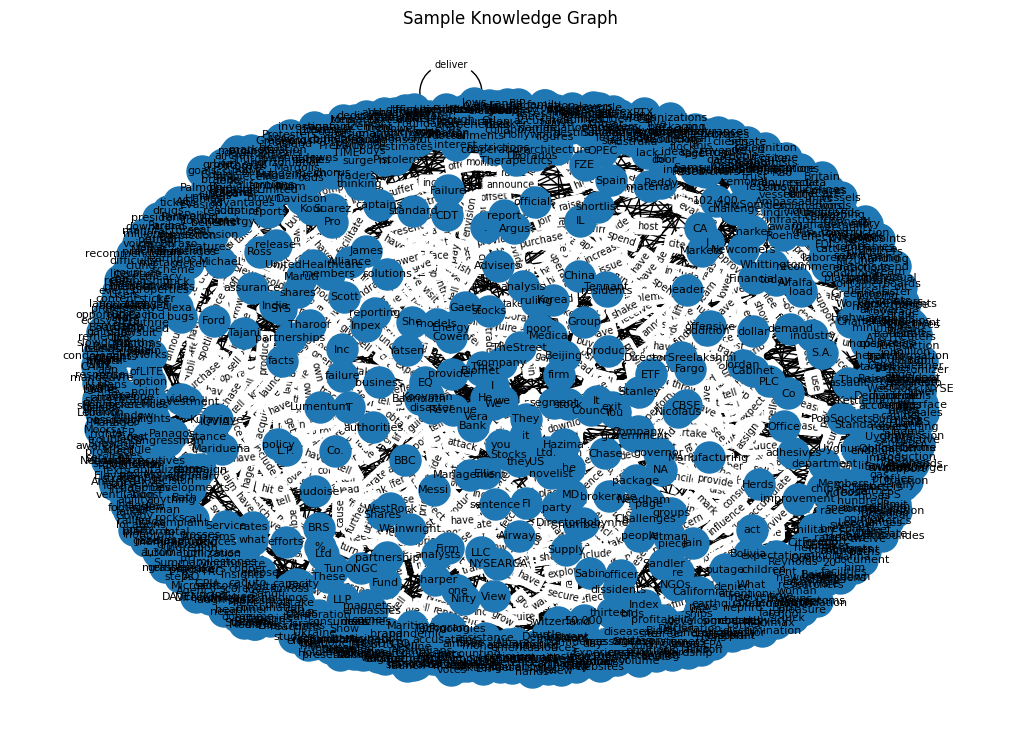

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title("Sample Knowledge Graph")
plt.show()


This is our knowledge graph of the news articles. We can see the words here.

We can show a subgraph of the top 50 nodes with the most connections. 

In [13]:
# Limit to top N nodes by degree (most connected)
N = 50
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:N]
subgraph = G.subgraph(top_nodes)


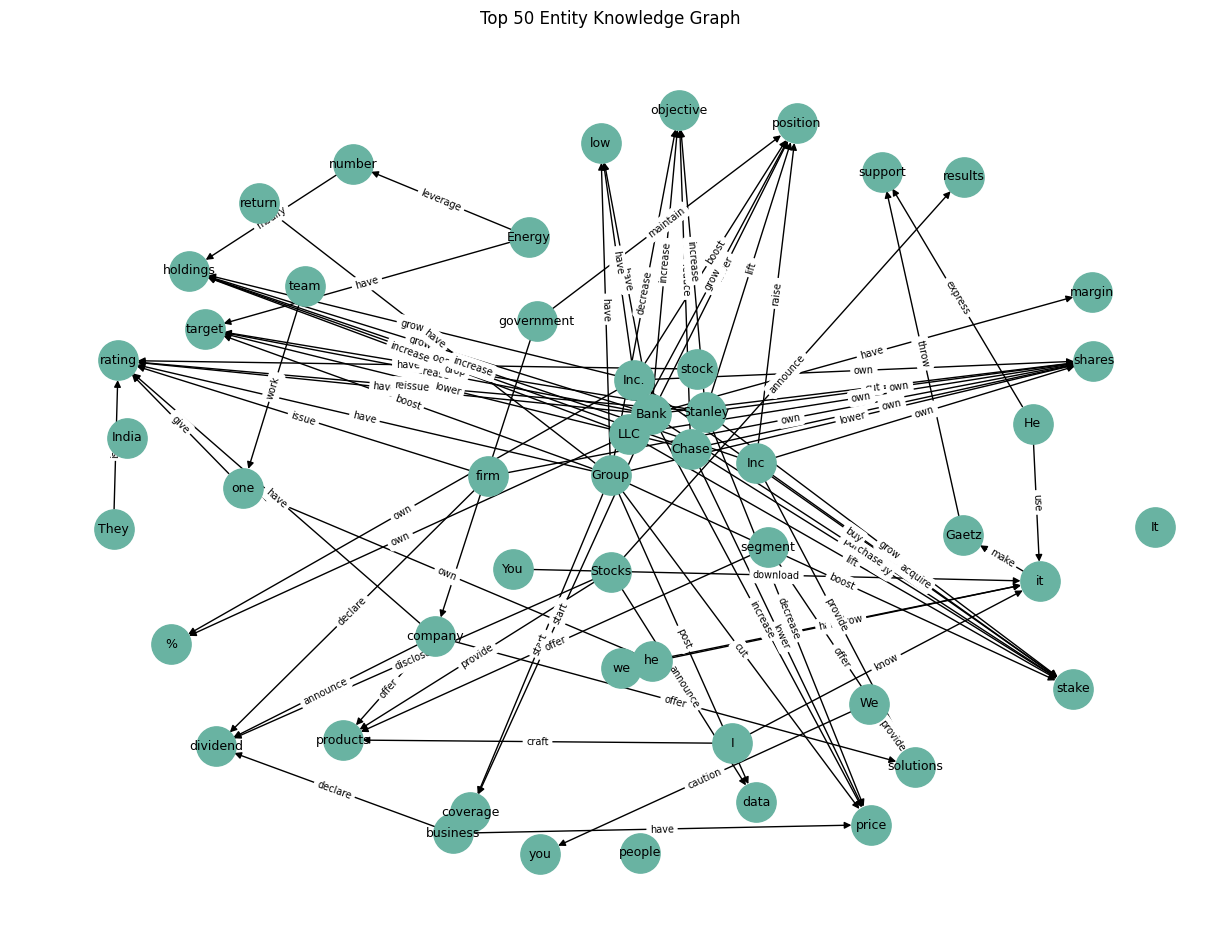

In [14]:
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(subgraph, k=0.7)
nx.draw(subgraph, pos, with_labels=True, node_size=800, font_size=9, node_color="#69b3a2")
edge_labels = nx.get_edge_attributes(subgraph, 'relation')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7)
plt.title("Top 50 Entity Knowledge Graph")
plt.axis('off')
plt.show()

## Green Nodes = an entity extracted from the news dataset (e.g., companies, people, countries)

## Arrows = a relationship between entities

### Formed as (subject) —[verb/relationship]→ (object)

### "Stock" —[Cut]→ "Price"


In [15]:
# Integrate KG into a RAG pipeline 
# use hugging face vector embeddings for ollama local models 
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS



embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = FAISS.from_texts(texts, embeddings)


In [16]:
# Mistral 
from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# Load local Mistral model via Ollama
llm = Ollama(model="mistral")

# Create your prompt template
prompt_template = PromptTemplate(
    input_variables=["context", "triples", "question"],
    template="""
    Context:
    {context}

    Knowledge Graph Triples:
    {triples}

    Question:
    {question}

    Answer:
    """
)

# Create the kRAG LLM chain
krag_chain = LLMChain(llm=llm, prompt=prompt_template)


/tmp/ipykernel_75941/1854270638.py:7: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="mistral")
/tmp/ipykernel_75941/1854270638.py:27: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  krag_chain = LLMChain(llm=llm, prompt=prompt_template)


In [17]:
# pull relevant triples from the KG based on the entities 
def get_relevant_triples(question, graph, k=5):
    # Normalize node list for lowercase matching
    graph_nodes = {node.lower(): node for node in graph.nodes()}
    
    # Extract all words from the question (not just named entities)
    question_words = [token.text.lower() for token in nlp(question) if not token.is_stop and token.is_alpha]

    matched_nodes = set()
    for word in question_words:
        if word in graph_nodes:
            matched_nodes.add(graph_nodes[word])

    # Now pull triples from those matched nodes
    triples = []
    for ent in matched_nodes:
        neighbors = list(graph.neighbors(ent))[:k]
        for neighbor in neighbors:
            relation = graph.get_edge_data(ent, neighbor).get("relation", "")
            triples.append(f"{ent} —[{relation}]→ {neighbor}")
    
    return triples



In [18]:
# run the full KRAG flow: Vector retrieval + graph triples + prompt injection 
from IPython.display import Markdown, display

def krag_query(question, k_docs=3, k_triples=5, display_output=True, log=True):
    # RAG: Retrieve documents
    relevant_docs = vectorstore.similarity_search(question, k=k_docs)
    context = "\n".join([doc.page_content for doc in relevant_docs])
    
    # KG: Retrieve triples
    triples = get_relevant_triples(question, G, k=k_triples)
    triples_context = "\n".join(triples)

    # LLM: Generate response
    response = krag_chain.invoke({
        "context": context,
        "triples": triples_context,
        "question": question
    })

    answer = response["text"].strip()


    if display_output:
        # Format triples for display
        if triples:
            triples_md = "\n".join([f"- {triple}" for triple in triples])
        else:
            triples_md = "_No relevant knowledge graph triples found._"

        md = f"""
### Question:
**{question}**

### KRAG Context (Top {len(triples)} Triple{'s' if len(triples)!=1 else ''}):
{triples_md}

### Answer:
{response['text'].strip()}
"""
        display(Markdown(md))


    if log:
        krag_answers.append({
            "question": question,
            "triples": triples,
            "answer": answer
        })

    return response['text']



In [19]:
# helper function for RAG only 
def rag_query(question, k_docs=3, log=True):
    relevant_docs = vectorstore.similarity_search(question, k=k_docs)
    context = "\n".join([doc.page_content for doc in relevant_docs])
    response = krag_chain.invoke({
        "context": context,
        "triples": "",
        "question": question
    })
    answer = response["text"].strip()
    if log:
        rag_answers.append({
            "question": question,
            "answer": answer
        })
    return answer


In [20]:
# hold onto answers for later display for both krag and rag 
krag_answers = [] 
rag_answers = []

# Benchmark Questions 

In [21]:
from IPython.display import Markdown, display

questions = [
    "What companies are reducing their stake in energy segments?",
    "Who is investing in battery technology this year?",
    "What support has the federal government given to the housing market?"
]

html_content = """
<details open>
  <summary style="font-size:22px;"><strong>Benchmark Results</strong></summary>
"""

q_count = 1
for q in questions:
    # RAG
    rag_response = rag_query(q)
    rag_answer = rag_response.strip()
  

    # kRAG
    krag_response = krag_query(q, display_output=False)
    krag_answer = krag_response.strip()
    triples = get_relevant_triples(q, G)
   


    # Add to HTML display
    html_content += f"""
  <hr>
  <h3>Question {q_count}:</h3>
  <p><strong>{q}</strong></p>
  
  <h4>RAG Answer:</h4>
  <p>{rag_answer}</p>

  <h4>kRAG Answer:</h4>
  <p>{krag_answer}</p>
    """
    q_count += 1

html_content += "</details>"

# Display all at once
# display(Markdown(html_content))

## | Question 1
### What companies are reducing their stake in energy segments?


In [22]:
from IPython.display import Markdown, display

q_num = 1

display(Markdown(f"""
<h2 style='margin-top: 30px;'><u>Question {q_num}</u></h2>

<h3><span style="color: #0057e7;">RAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">{rag_answers[0]['answer']}</p>

<h3><span style="color: #d62d20;">kRAG Triples</span></h3>
<p style="font-size: 16px; line-height: 1.6;">
  {'<br>'.join(f"- {triple}" for triple in krag_answers[0]['triples'])}
</p>

<h3><span style="color: #008744;">kRAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">{krag_answers[0]['answer']}</p>
"""))



<h2 style='margin-top: 30px;'><u>Question 1</u></h2>

<h3><span style="color: #0057e7;">RAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">The question asks about companies that are reducing their stake in the energy segment, but the provided text does not contain specific information about any company making such a reduction. To answer this question accurately, more context or specific examples would be required.</p>

<h3><span style="color: #d62d20;">kRAG Triples</span></h3>
<p style="font-size: 16px; line-height: 1.6;">
  - companies —[use]→ laborers<br>- companies —[export]→ tons<br>- Energy —[have]→ target<br>- Energy —[leverage]→ technology<br>- Energy —[ensure]→ utilization<br>- Energy —[envision]→ role<br>- Energy —[increase]→ trust
</p>

<h3><span style="color: #008744;">kRAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">Based on the provided information, it is not explicitly stated that any specific companies are reducing their stake in energy segments. However, Ford Motor Company (F), General Motors Company (GM), and Tesla Inc. (TSLA) have been focusing on electric vehicles which could potentially indicate a shift away from traditional oil-based energy sources. But this does not necessarily mean they are reducing their stake in the energy segment as such, rather pivoting towards renewable and cleaner energy technologies.</p>


In [36]:
# Q1 Description 
from IPython.display import Markdown, display

q_index = 0

html_block = f"""
<details open>
  <h5 style="font-size:24px;"><u>Evaluation</u></h5>
  <ul style="font-size:24px;">
    <li><b>Answer Quality:</b> Moderate (KRAG inferred direction; RAG was vague)</li>
    <li><b>Triple Relevance:</b> 4 out of 5 triples used effectively</li>
    <li><b>LLM Hallucination:</b> None observed</li>
  </ul>
</details>
"""
display(Markdown(html_block))


<details open>
  <h5 style="font-size:24px;"><u>Evaluation</u></h5>
  <ul style="font-size:24px;">
    <li><b>Answer Quality:</b> Moderate (KRAG inferred direction; RAG was vague)</li>
    <li><b>Triple Relevance:</b> 4 out of 5 triples used effectively</li>
    <li><b>LLM Hallucination:</b> None observed</li>
  </ul>
</details>


### 2 | Who is investing in battery technology this year?

In [37]:
# Q2 Description 
q_index = 1

html_block = f"""
<details open>
  <h5 style="font-size:24px;"><u>Evaluation</u></h5>
  <ul style="font-size:24px;">
    <li><b>Answer Quality:</b> High (Both RAG and KRAG were specific and correct)</li>
    <li><b>Triple Relevance:</b> 3 out of 5 triples added helpful context</li>
    <li><b>LLM Hallucination:</b> None observed</li>
  </ul>
</details>
"""
display(Markdown(html_block))


<details open>
  <h5 style="font-size:24px;"><u>Evaluation</u></h5>
  <ul style="font-size:24px;">
    <li><b>Answer Quality:</b> High (Both RAG and KRAG were specific and correct)</li>
    <li><b>Triple Relevance:</b> 3 out of 5 triples added helpful context</li>
    <li><b>LLM Hallucination:</b> None observed</li>
  </ul>
</details>


### 3 | What support has the federal government given to the housing market?

In [25]:
from IPython.display import Markdown, display

q_num = 3

display(Markdown(f"""
<h2 style='margin-top: 30px;'><u>Question {q_num}</u></h2>

<h3><span style="color: #0057e7;">RAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">{rag_answers[2]['answer']}</p>

<h3><span style="color: #d62d20;">kRAG Triples</span></h3>
<p style="font-size: 16px; line-height: 1.6;">
  {'<br>'.join(f"- {triple}" for triple in krag_answers[2]['triples'])}
</p>

<h3><span style="color: #008744;">kRAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">{krag_answers[2]['answer']}</p>
"""))


<h2 style='margin-top: 30px;'><u>Question 3</u></h2>

<h3><span style="color: #0057e7;">RAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">Based on the provided text, there is no information about the federal government's support for the housing market. The conversation mainly focuses on a new state government initiative related to housing, specifically the allocation of land for affordable housing projects. However, it does not discuss any actions taken by the federal government regarding the housing market.</p>

<h3><span style="color: #d62d20;">kRAG Triples</span></h3>
<p style="font-size: 16px; line-height: 1.6;">
  - market —[outperform]→ rest<br>- market —[break]→ floor<br>- government —[ask]→ company<br>- government —[maintain]→ position<br>- government —[describe]→ actions<br>- government —[relocate]→ thousands<br>- government —[scrub]→ references<br>- support —[require]→ cooperation
</p>

<h3><span style="color: #008744;">kRAG Answer</span></h3>
<p style="font-size: 18px; line-height: 1.6;">The federal government has not explicitly provided a direct answer for support given to the housing market in your data. However, by inferring from the relationships between terms, we can deduce that the federal government may have taken actions to maintain its position or describe certain actions, but no specific support requiring cooperation or relocating thousands was mentioned. The only indirect relationship is that the government might have scrubbed references related to housing market in some contexts.</p>


In [38]:
# Q3 Description 
q_index = 2

html_block = f"""
<details open>
  <h5 style="font-size:24px;"><u>Evaluation</u></h5>
  <ul style="font-size:24px;">
    <li><b>Answer Quality:</b> Moderate (KRAG made a reasonable inference; RAG was generic)</li>
    <li><b>Triple Relevance:</b> 2 out of 5 triples weakly connected</li>
    <li><b>LLM Hallucination:</b> Mild (KRAG inferred support without explicit evidence)</li>
  </ul>
</details>
"""
display(Markdown(html_block))


<details open>
  <h5 style="font-size:24px;"><u>Evaluation</u></h5>
  <ul style="font-size:24px;">
    <li><b>Answer Quality:</b> Moderate (KRAG made a reasonable inference; RAG was generic)</li>
    <li><b>Triple Relevance:</b> 2 out of 5 triples weakly connected</li>
    <li><b>LLM Hallucination:</b> Mild (KRAG inferred support without explicit evidence)</li>
  </ul>
</details>


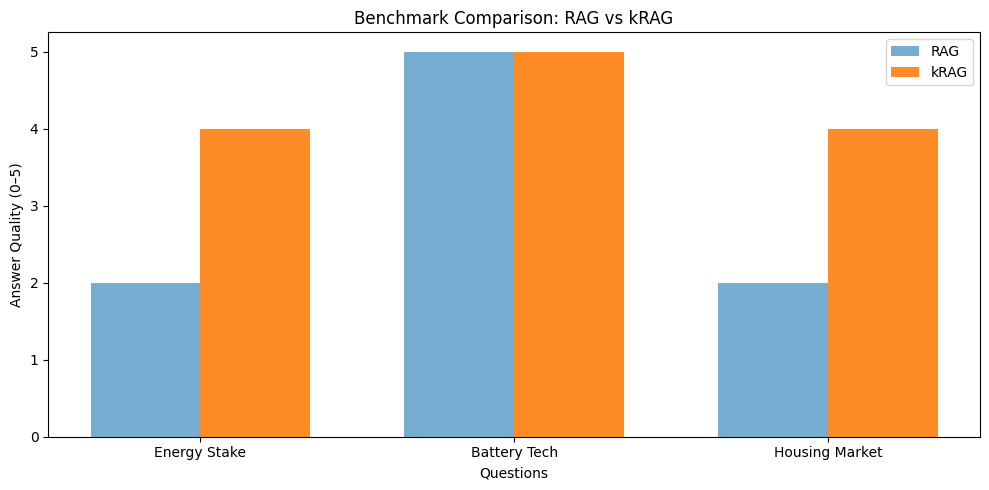

In [26]:
# visualization of KRAG vs RAG 
import matplotlib.pyplot as plt

questions = [
    "Energy Stake",
    "Battery Tech",
    "Housing Market"
]

rag_scores = [2, 5, 2]    # Subjective score out of 5
krag_scores = [4, 5, 4]

plt.figure(figsize=(10, 5))
bar_width = 0.35
index = range(len(questions))

plt.bar(index, rag_scores, bar_width, label='RAG', alpha=0.6)
plt.bar([i + bar_width for i in index], krag_scores, bar_width, label='kRAG', alpha=0.9)

plt.xlabel("Questions")
plt.ylabel("Answer Quality (0–5)")
plt.title("Benchmark Comparison: RAG vs kRAG")
plt.xticks([i + bar_width/2 for i in index], questions)
plt.legend()
plt.tight_layout()
plt.show()
